#**Ejercicio 01 - Pronóstico adaptativo**

##**Descripción del problema**
Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

##**Descripción del problema en términos de los datos**
La carpeta datos/precios/ contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

##**Aproximaciones posibles**
En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

#**Definición de las clases del modelo**
En esta Sección se definen las clases de Python con las que se aborda el problema.

##**Adaline para pronóstico adaptativo**
En el bloque de código inferior, se define la clase Adaline con los atributos: rezagom kearning_rate, momentum, max_epochs, shuffle, random_state y warm_start. Con estos atributos se entrena el Adaline para pronóstico adaptativo de forma _online_ con learning_rate y momentum. 

Los métodos de esta clase con su respectiva descripción se listan a continuación:
*   **_fit_(self, X, Y)**: Este método permite entrenar el Adaline para pronóstico adaptativo de forma online. Como parámetros el método recibe el objeto Adaline, la matriz o vector de entrenamiento "X" y el vector de salidas "Y".
*   **_predict_(self, X)**: Este método permite predecir el valor "Y" de salida a partir de un valor "X" de entrada.  Como parámetros, el método recibe el objeto Adaline y el vector "X" de entradas para la predicción.
*   **_predictNextDays_(self, X, days = 7)**: Este método permite predecir los días siguientes a partir de un valor "X" de entrada. Como parámetros, el método recibe el objeto Adaline, el vector "X" de entradas para la predección y el número de días a predecir a partir del "X" (por defecto el valor de este parámetro es 7). En este método primero se calcula la predicción del siguiente día, al igual que el método _predict_, y el valor de predicción toma un lugar en las entradas "X" para la siguiente predicción. Este procedimiento se realiza hasta completar el número de días establecido como parámetro. 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import statistics
#DEFINIMOS LA CLASE ADALINE
class Adaline:
    def __init__(self,
                 rezago,              # Rezago del modelo
                 learning_rate=0.001, # tasa de aprendizaje
                 momentum = 0.9,      # momentum
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #

        self.rezago = rezago
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None
        self.error2promedioEntrenamiento = 1
        self.error2promedioTest = 1
        self.mae = 1
        self.maeEntrenamiento = 1
        self.forecastedTest = []
        self.forecastedEntrenamiento = []
        self.entrenamiento = []
        self.yTest = []
        self.XTest = []

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)
        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            v = 0 #Indicador del momentum
            vIntercepto = 0 #Indicador del momentum intercepto
            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]

                v = self.momentum*v + 2 * self.learning_rate * e * X[i,:]
                self.coef_ += v
                vIntercepto = self.momentum*vIntercepto + 2*self.learning_rate*e
                self.intercept_ += vIntercepto
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u
    
    def predictNextDays(self, X, days = 7):
      y = []
      if not isinstance(X, np.ndarray):
        X = np.array(X)
      for iteracion in range (0, days):
        forecast = self.predict(X)
        y.append(forecast)
        X = np.append(X, forecast)
        X = np.delete(X, 0)
      return np.array(y)

## **Modelo para la evaluación de diferentes Adalines**
En el bloque de código inferior se define la clase Modelo con los siguientes atributos: data, learning_rate, momentum, max_epochs, shuffle, random_state, warm_start, transformacion, dias, limiteDeRezago. Estos atributos permiten evaluar diferentes Adalines que dependen de los rezagos, momentum y learning_rate. 

Los métodos de esta clase con su respectiva descripción se listan a continuación:
* **_probar_(self)**: Este método permite probar un conjunto de Adalines a partir de una transformación, learning_rate y momentum que se definen en el constructor. Como parámetro, el método recibe un objeto de tipo Modelo. En este método se entrenan Adalines de 10 rezagos hasta el límite (17 por defecto) que se define en el constructor. Además, se prueba el error promedio (MAE) de cada Adaline para la predicción de los siguientes n días.
* **_probarDias_(self, adaline, rezago)**: Este método permite encontrar el error promedio (MAE) en la predicción de "n" días siguientes para un Adaline según su número de rezagos. Como parámetros, este método recibe un objeto de tipo Modelo, un objeto de tipo Adaline y el número de rezagos del Adaline.
* **_mejorModelo_(self)**: Este método permite encontrar el mejor Adaline según su error promedio (MAE). Como parámetro, este método recibe un objeto de tipo Modelo. 

In [0]:
#DEFINIMOS LA CLASE MODELO
class Modelo :
  
  def __init__(self,
                 data,                # Vector de numpy con los datos normalizados a entrenar y testear
                 learning_rate=0.001, # tasa de aprendizaje
                 momentum = 0.9,      # momentum para el aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   # estado aleatorio predefinido
                 warm_start=False,    # si tiene coeficientes ya asignados
                 transformacion=None, # transformación a utilizar en Y
                 dias = 7,            # horizonte de tiempo a pronosticar
                 limiteRezago = 17    # máximo rezago a evaluar
                 ):           
              
      self.limiteRezago = limiteRezago
      self.learning_rate = learning_rate
      self.momentum = momentum
      self.max_epochs = max_epochs
      self.shuffle = shuffle
      self.random_state = random_state
      self.warm_start = warm_start
      self.transformacion = transformacion
      self.dias = dias
      if not isinstance(data, np.ndarray):
        data = np.array(data)
      self.data = data
      self.adalines = []
      self.error2promedio = 1
      self.maeDias = 1
      self.scaler = MinMaxScaler()

  def probar(self):
      #Aplicamos la transformación a los datos
      if self.transformacion == "log":
        self.data = np.log(self.data)
      elif self.transformacion == "sqrt":
        self.data = np.power(self.data, 1/2)
      elif self.transformacion == "sqrt3":
        self.data = np.power(self.data, 1/3)
      elif self.transformacion == "e":
        self.data = np.exp(self.data)
      elif self.transformacion == "pow2":
        self.data = np.power(self.data, 2)

      #APLICAMOS EL ESCALAMIENTO
      self.data = self.scaler.fit_transform(np.array(self.data).T)
      #Separamos entrenamiento y test
      self.dataEntrenamiento = self.data[0:len(self.data)-self.dias]

      for rezago in range (10, self.limiteRezago + 1):
        self.yEntrenamiento = np.ndarray(shape = (self.dataEntrenamiento.size - rezago,1)) #VECTOR DE OBSERVACIONES
        self.XEntrenamiento = np.ndarray(shape = (self.dataEntrenamiento.size - rezago, rezago)) #MATRIZ CON REZAGOS
        # ARMAMOS LA MATRIZ SEGUN EL NUMERO DE REZAGOS Y LAS OBSERVACIONES 
        for observacionY in range (rezago, self.dataEntrenamiento.size):
          for rezagoI in range(observacionY - rezago, observacionY):
            self.XEntrenamiento[observacionY - rezago][rezagoI - (observacionY - rezago)] = self.dataEntrenamiento[rezagoI]
          self.yEntrenamiento[observacionY - rezago] = self.dataEntrenamiento[observacionY]
        
        # creamos el modelo
        adaline = Adaline(
          rezago = rezago,
          learning_rate= self.learning_rate,  
          momentum = self.momentum,
          max_epochs=self.max_epochs,       
          shuffle=self.shuffle,       
          random_state=self.random_state, 
          warm_start=self.warm_start)  
        
        #Entrenamos el modelo
        errors2, forecasted = adaline.fit(self.XEntrenamiento, self.yEntrenamiento)
        adaline.error2promedioEntrenamiento = np.mean(errors2)
        
        try:
          adaline.forecastedEntrenamiento = forecasted.copy()
          adaline.entrenamiento = self.yEntrenamiento.copy()
          adaline.maeEntrenamiento = mean_absolute_error(adaline.entrenamiento, adaline.forecastedEntrenamiento)
          adaline.mae, adaline.forecastedTest, adaline.XTest = self.probarDias(adaline, rezago)
          self.adalines.append(adaline)
        except:
          pass
        
  def probarDias(self, adaline, rezago):
    self.dataTest =  self.data[len(self.data)-self.dias:]
    self.XTest = self.data[len(self.data)-self.dias-rezago:len(self.data)-self.dias].T
    forecasted = adaline.predictNextDays(self.XTest)
    self.dataTest = self.scaler.inverse_transform(self.dataTest)
    forecasted = self.scaler.inverse_transform(forecasted)
    if self.transformacion == "log":
      self.dataTest = np.exp(self.dataTest)
      forecasted = np.exp(forecasted)
    elif self.transformacion == "pow2":
      self.dataTest = np.power(self.dataTest, 1/2)
      forecasted = np.power(forecasted,1/2)
    elif self.transformacion == "sqrt":
      self.dataTest = np.power(self.dataTest, 2)
      forecasted = np.power(forecasted,2)
    elif self.transformacion == "sqrt3":
      self.dataTest = np.power(self.dataTest, 3)
      forecasted = np.power(forecasted,3)
    elif self.transformacion == "e":
      self.dataTest = np.log(self.dataTest)
      forecasted = np.log(forecasted)
    maeTest = mean_absolute_error(self.dataTest, forecasted)
    return maeTest, forecasted, self.dataTest.copy()
    
  def mejorModelo(self):
    mae = 100
    mejorModelo = self.adalines[0]
    for adaline in self.adalines:
      if adaline.mae < mae:
        mejorModelo = adaline
        maeEntrenamiento = adaline.mae 
    return mejorModelo

  def vectorDeErroresPorModelo(self):
    mae = []
    for adaline in self.adalines:
      mae.append(adaline.mae)
    return mae

#**Carga de datos**
En esta Sección se realiza la carga de los datos, esto incluye los datos del precio de la electricidad y del IPC.


## **Precio de la energía**
En este bloque de código se cargan los precios de la energía desde 1995 hasta 2018 desde github. Estos precios se guardan en un _DataFrame_ de _pandas_ y están dividos por horas por cada día, como se mumestra en el método _head()_ al final del bloque.

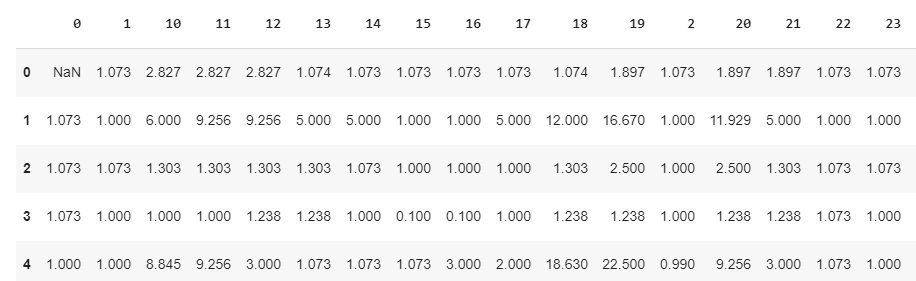

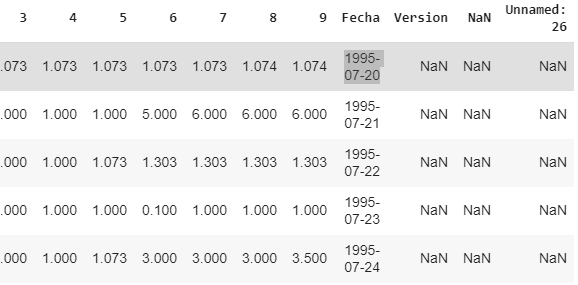


In [20]:
# CARGA DE DATOS
dataFrame1995_2018 = pd.DataFrame()

# LECTURA DE DATOS DE 1995 A 1999
for i in range (1995, 2000):
  url = "https://github.com/ANN-2019-2/evaluacion-DavidMosquera/blob/master/datos/precios/Precio_Bolsa_Nacional_($kwh)_"+str(i)+".xlsx?raw=true"
  dataFramePorAno = pd.read_excel(url, 
                 encoding = 'latin-1',
                 skiprows=3)
  dataFrame1995_2018 = dataFrame1995_2018.append(dataFramePorAno, ignore_index=False, verify_integrity=False, sort=None)

# LECTURA DE DATOS DE 2000 A 2015
for i in range (2000, 2016):
  url = "https://github.com/ANN-2019-2/evaluacion-DavidMosquera/blob/master/datos/precios/Precio_Bolsa_Nacional_($kwh)_"+str(i)+".xlsx?raw=true"
  dataFramePorAno = pd.read_excel(url, 
                 encoding = 'latin-1',
                 skiprows=2)
  dataFrame1995_2018 = dataFrame1995_2018.append(dataFramePorAno, ignore_index=False, verify_integrity=False, sort=None)

# LECTURA DE DATOS DE 2016 A 2018
for i in range (2016, 2019):
  url = "https://github.com/ANN-2019-2/evaluacion-DavidMosquera/blob/master/datos/precios/Precio_Bolsa_Nacional_($kwh)_"+str(i)+".xls?raw=true"
  dataFramePorAno = pd.read_excel(url, 
                 encoding = 'latin-1',
                 skiprows=2)
  dataFrame1995_2018 = dataFrame1995_2018.append(dataFramePorAno, ignore_index=False, verify_integrity=False, sort=None)

dataFrame1995_2018.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,3,4,5,6,7,8,9,Fecha,Version,NaN,Unnamed: 26
0,NaN,1.073,2.827,2.827,2.827,1.074,1.073,1.073,1.073,1.073,1.074,1.897,1.073,1.897,1.897,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,1.074,1995-07-20,NaN,NaN,NaN
1,1.073,1.000,6.000,9.256,9.256,5.000,5.000,1.000,1.000,5.000,12.000,16.670,1.000,11.929,5.000,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,6.000,1995-07-21,NaN,NaN,NaN
2,1.073,1.073,1.303,1.303,1.303,1.303,1.073,1.000,1.000,1.000,1.303,2.500,1.000,2.500,1.303,1.073,1.073,1.000,1.000,1.073,1.303,1.303,1.303,1.303,1995-07-22,NaN,NaN,NaN
3,1.073,1.000,1.000,1.000,1.238,1.238,1.000,0.100,0.100,1.000,1.238,1.238,1.000,1.238,1.238,1.073,1.000,1.000,1.000,1.000,0.100,1.000,1.000,1.000,1995-07-23,NaN,NaN,NaN
4,1.000,1.000,8.845,9.256,3.000,1.073,1.073,1.073,3.000,2.000,18.630,22.500,0.990,9.256,3.000,1.073,1.000,1.000,1.000,1.073,3.000,3.000,3.000,3.500,1995-07-24,NaN,NaN,NaN


##**IPC**
En este bloque de código se cargan los datos del IPC desde github. Estos datos se guardan en _DataFrame_ de _pandas_ como se muestra en el método _head()_ al final del bloque. 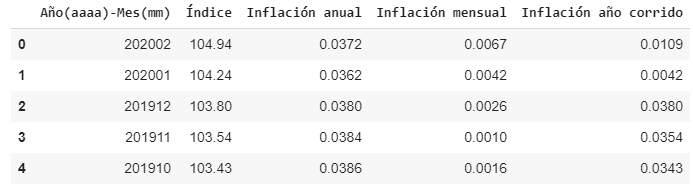

In [5]:
#CARGA DE DATOS DEL IPC
dataFrameIPC = pd.read_excel("https://github.com/ANN-2019-2/evaluacion-DavidMosquera/blob/master/datos/1.2.5.IPC_Serie_variaciones.xlsx?raw=true", 
                 encoding = 'latin-1',
                 skiprows=12)
dataFrameIPC.head()

,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido
0,202002,104.94,0.0372,0.0067,0.0109
1,202001,104.24,0.0362,0.0042,0.0042
2,201912,103.80,0.0380,0.0026,0.0380
3,201911,103.54,0.0384,0.0010,0.0354
4,201910,103.43,0.0386,0.0016,0.0343


#**Acondicionamiento de los datos**
En esta Sección se acondicionan los datos para la construcción y evaluación de los diferentes Adalines de pronóstico adaptativo.

##**Fecha de precio de la energía en formato del IPC**
En el siguiente bloque de código, se toman el _DataFrame_ que contiene los precios de la energía por día para establecer la fecha en el formato del IPC. Este formato sigue la convención "aaaamm"—_e.g._ si el precio de la energía tiene como fecha "1995-07-20", se debe transformar a la convención del IPC como "199507". Esta fecha que sigue la convención del IPC se almacena en una nueva columna con nombre "Año(aaaa)-Mes(mm)" en el _DataFrame_ de precios. Se lleva a cabo este cambio en el formato de la fecha para hacer posteriormente el emparejamiento entre el _DataFrame_ de precios y del IPC.

In [0]:
#Iteración por filas del DataFrame, ENCONTRAR LA FECHA EN FORMATO DEL IPC PARA LA NORMALIZACION DE LOS DATOS
dataFrame1995_2018 = dataFrame1995_2018.dropna(subset=["Fecha"])
fechas = dataFrame1995_2018["Fecha"]
fechasAct = []
for fecha in fechas:
  fecha = str(fecha)[0:4]+str(fecha)[5:7]
  fechasAct.append(int(fecha))
dataFrame1995_2018["Año(aaaa)-Mes(mm)"] = fechasAct

##**Cálculo del precio promedio de la energía por día**
En el siguiente bloque de código, se toman los precios de la energía por hora por cada día y se calcula el promedio. Este promedio se almacena en una nueva columna con nombre "promedio" del _DataFrame_ de precios. En caso de que el promedio tenga un valor de "nan", se descarta este valor con el método _dropna_(subset=["promedio"]). Finalmente, se descartan las columnas que no son necesarias para la construcción de los Adalines como los valores por hora de la energía y la versión. 

In [0]:
#CALCULAMOS EL PROMEDIO DIARIO (SIN CORRECCION DEL IPC)
dataFrame1995_2018["promedio"] = dataFrame1995_2018[['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']].mean(axis = 1, skipna= True, numeric_only=True)
#DROPEAMOS EL NAN DEL PROMEDIO
dataFrame1995_2018 = dataFrame1995_2018.dropna(subset=['promedio'])
#DROPEAMOS LAS COLUMNAS NO RELEVANTES
dataFrame1995_2018 = dataFrame1995_2018.drop(columns=["Version",'0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])

##**Emparejamiento de los precios y el IPC**
En el siguiente bloque de código, se emparejan los _DataFrame_ de precios y del IPC a partir de la columna "Año(aaaa)-Mes(mm)". Con este emparejamiento se descartan los datos del IPC que estén fuera del rango de las fechas de los precios de la energía.

In [0]:
#HACEMOS MERGE CON EL IPC
dataFrameMerged = dataFrame1995_2018.merge(dataFrameIPC, left_on="Año(aaaa)-Mes(mm)", right_on="Año(aaaa)-Mes(mm)")

##**Transformación del precio promedio por día a partir del IPC**
En el siguiente bloque de código, se transforma el precio promedio por día al valor del día con el máximo IPC. Esta transformación se lleva a cabo con la siguiente ecuación: 
\begin{equation}
x' = \frac{x * I_{max}}{I}
\end{equation}
Donde _x'_ es el precio promedio por día con la transformación del IPC; _x_ es el precio promedio por día; _Imax_ es el IPC máximo; y, finalmente, _I_ es el IPC del precio promedio _x_.

In [0]:
#HACEMOS LA TRANSFORMACION CON EL IPC DEL PROMEDIO
maximoIndice = dataFrameMerged.iloc[dataFrameMerged['Índice'].idxmax()]
indice = maximoIndice["Índice"]

#LLEVAMOS LOS PRECIOS AL MAXIMO IPC 
precioPromedioConIPC = []
for i, fila in dataFrameMerged.iterrows():
  precio = fila["promedio"]*indice / fila["Índice"]
  precioPromedioConIPC.append(precio)
precioPromedioConIPC = np.array([precioPromedioConIPC])

#**Construcción y prueba de Adalines para pronóstico adaptativo**
En esta Sección se construyen y prueban los diferentes Adalines para el pronóstico adaptativo del precio promedio diário de la energía en Colombia. Para cada transformación se prueban 6300 Adalines difererentes con un paso de 0.01 en el cambio del momentum y learning_rate. Este número se obitiene de multiplicar las interaciones para el momentum, el learning_rate y el número de rezagos a evaluar como se muestra a continuación: \begin{equation}(30_{momentums}*30_{learing-rates}*7_{rezagos}) = 6300\end{equation} 

##**Adalines: Sin transformación**
En el siguiente bloque de código, se prueban Adalines sin transformación con diferentes momentums, rezagos y learning_rates. Para cada combinación de momentum y learning_rate se obtiene el mejor Adaline y se agrega a la lista de mejores modelos.

In [0]:
#PRUEBA SIN TRANSFORMACION
iteracionesPorModelo = 30
mae = []
rezagos = []
forecastes = []
yTest = []
maeDiasVector = []
mejorMaeDias = 1
mejorModeloDeModelos = None
learing_rates = []
momentums = []
modelos = []
mejoresModelos = []
paso = 0.01
mejorModelo = None
maeModelo = 100
momentum_prueba = 0.4
#ITERACIONES POR MODELO
for _ in range(0,iteracionesPorModelo):
  #ITERACIONES POR MOMENTUM
  learning_rate_prueba = 0.4
  for _ in range(0,iteracionesPorModelo):
    #ITERACIONES POR LEARNING_RATE
    modelo = Modelo(
        precioPromedioConIPC, 
        max_epochs=1, 
        transformacion= None,
        learning_rate = learning_rate_prueba,
        momentum = momentum_prueba
        )
    modelo.probar()
    mejorModelo = modelo.mejorModelo()
    mejoresModelos.append(mejorModelo)
    learning_rate_prueba = learning_rate_prueba - paso
  momentum_prueba = momentum_prueba-paso

###**Resultados**
Luego de probar los 6300 diferentes Adalines sin transformación, se obtiene que el mejor número de rezagos es 17, con un learning_rate y momentum de 0.11. Con esta configuración, el MAE para el pronóstico de los siguientes siete días es igual a 35.95 aproximadamente. Finalmente, se muestran las gráficas de predicción de los siguientes siete días y la gráfica de dispersión en el entrenamiento para el mejor Adaline sin transformación.  

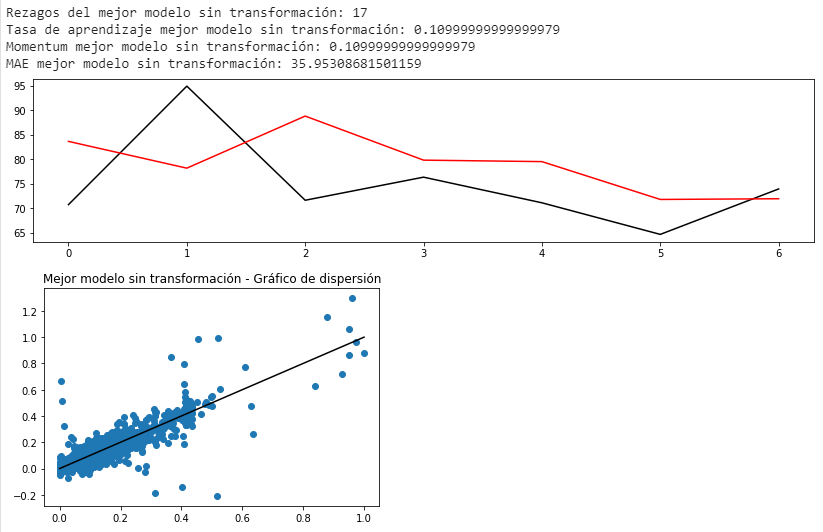

Rezagos del mejor modelo sin transformación: 17
Tasa de aprendizaje mejor modelo sin transformación: 0.10999999999999979
Momentum mejor modelo sin transformación: 0.10999999999999979
MAE mejor modelo sin transformación: 35.95308681501159


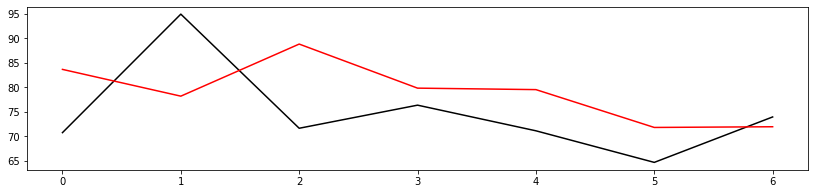

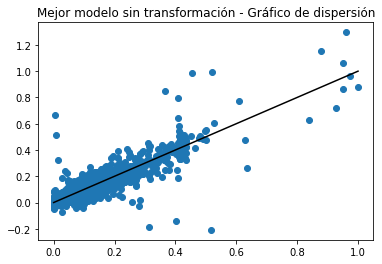

In [14]:
maeModelo = 100
for modelo in mejoresModelos: 
  if modelo.mae < maeModelo:
    maeModelo = modelo.mae
    mejorModeloDeModelos = modelo

plt.figure(figsize=(14,3))
plt.plot(mejorModeloDeModelos.XTest, color = "black")
#plt.plot(mejoresModelos[0].forecastedEntrenamiento, color="red")
plt.plot(mejorModeloDeModelos.forecastedTest, color = "red")
plt.figure()
plt.title("Mejor modelo sin transformación - Gráfico de dispersión")
plt.plot([0,1],[0,1], color = "black")
plt.scatter(np.array(mejorModeloDeModelos.entrenamiento), np.array(mejorModeloDeModelos.forecastedEntrenamiento))
print("Rezagos del mejor modelo sin transformación: "+str(mejorModelo.rezago))
print("Tasa de aprendizaje mejor modelo sin transformación: "+str(mejorModelo.learning_rate))
print("Momentum mejor modelo sin transformación: "+str(mejorModelo.momentum))
print("MAE mejor modelo sin transformación: "+str(mejorModelo.mae))


##**Adalines: Logaritmo natural**
En el siguiente bloque de código, se prueban Adalines con la trasformación a logaritmo natrural con diferentes momentums, rezagos y learning_rates. Para cada combinación de momentum y learning_rate se obtiene el mejor Adaline y se agrega a la lista de mejores modelos. Es importante resaltar que, debido a las restricciones de dominio de la transformación—_e.g._ valores negativos o iguales a 0—, algunos Adalines se descarta sin pasar por la etapa de prueba de los siguientes siete días.

In [15]:
#PRUEBA CON LOGARITMO NATURAL
iteracionesPorModelo = 30
mejorModeloDeModelosLog = None
mejoresModelosLog = []
paso = 0.01
mejorModeloLog = None
maeModeloLog = 100
momentum_prueba = 0.4
#ITERACIONES POR MODELO

for _ in range(0,iteracionesPorModelo):
  #ITERACIONES POR MOMENTUM
  learning_rate_prueba = 0.4
  for _ in range(0,iteracionesPorModelo):
    #ITERACIONES POR LEARNING_RATE
    modelo = Modelo(
        precioPromedioConIPC, 
        max_epochs=1, 
        transformacion= "log",
        learning_rate = learning_rate_prueba,
        momentum = momentum_prueba
        )
    try:
      modelo.probar()
      mejorModeloLog = modelo.mejorModelo()
      mejoresModelosLog.append(mejorModeloLog)
    except:
      pass
    learning_rate_prueba = learning_rate_prueba - paso
  momentum_prueba = momentum_prueba-paso


Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in add
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_

###**Resultados**
Luego de probar los 6300 diferentes Adalines con logaritmo natural como transformación, se obtiene que el mejor número de rezagos es 12, con un learning_rate de 0.11 y momentum de 0.18. Con esta configuración, el MAE para el pronóstico de los siguientes siete días es igual a 24.73 aproximadamente. Finalmente, se muestran las gráficas de predicción de los siguientes siete días y la gráfica de dispersión en el entrenamiento para el mejor Adaline con logaritmo natural como transformación.
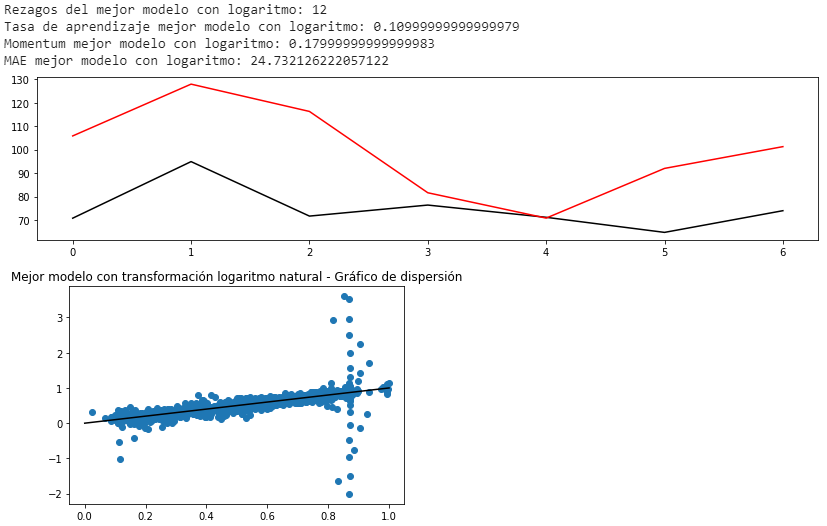  

Rezagos del mejor modelo con logaritmo: 12
Tasa de aprendizaje mejor modelo con logaritmo: 0.10999999999999979
Momentum mejor modelo con logaritmo: 0.17999999999999983
MAE mejor modelo con logaritmo: 24.732126222057122


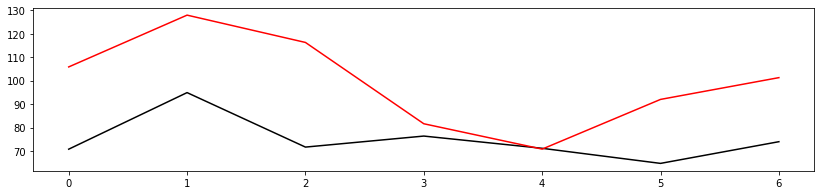

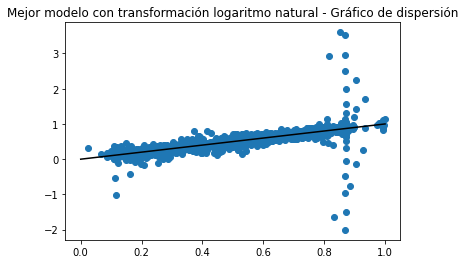

In [16]:
maeModeloLog = 100
for modelo in mejoresModelosLog: 
  if modelo is not None:
    if modelo.mae < maeModeloLog:
      maeModeloLog = modelo.mae
      mejorModeloDeModelosLog = modelo

plt.figure(figsize=(14,3))
plt.plot(mejorModeloDeModelosLog.XTest, color = "black")
#plt.plot(mejoresModelos[0].forecastedEntrenamiento, color="red")
plt.plot(mejorModeloDeModelosLog.forecastedTest, color = "red")
plt.figure()
plt.title("Mejor modelo con transformación logaritmo natural - Gráfico de dispersión")
plt.plot([0,1],[0,1], color = "black")
plt.scatter(np.array(mejorModeloDeModelosLog.entrenamiento), np.array(mejorModeloDeModelosLog.forecastedEntrenamiento))
print("Rezagos del mejor modelo con logaritmo: "+str(mejorModeloDeModelosLog.rezago))
print("Tasa de aprendizaje mejor modelo con logaritmo: "+str(mejorModeloDeModelosLog.learning_rate))
print("Momentum mejor modelo con logaritmo: "+str(mejorModeloDeModelosLog.momentum))
print("MAE mejor modelo con logaritmo: "+str(mejorModeloDeModelosLog.mae))

##**Adalines: Raíz cuadrada**
En el siguiente bloque de código, se prueban Adalines con la trasformación a raíz cuadrada con diferentes momentums, rezagos y learning_rates. Para cada combinación de momentum y learning_rate se obtiene el mejor Adaline y se agrega a la lista de mejores modelos. Es importante resaltar que, debido a las restricciones de dominio de la transformación—e.g. valores negativos—, algunos Adalines se descarta sin pasar por la etapa de prueba de los siguientes siete días.

In [17]:
#PRUEBA CON RAIZ CUADRADA
iteracionesPorModelo = 30
mejorModeloDeModelosSqrt = None
mejoresModelosSqrt = []
paso = 0.01
mejorModeloSqrt = None
maeModeloSqrt = 100
momentum_prueba = 0.4
#ITERACIONES POR MODELO

for _ in range(0,iteracionesPorModelo):
  #ITERACIONES POR MOMENTUM
  learning_rate_prueba = 0.4
  for _ in range(0,iteracionesPorModelo):
    #ITERACIONES POR LEARNING_RATE
    modelo = Modelo(
        precioPromedioConIPC, 
        max_epochs=1, 
        transformacion= "sqrt",
        learning_rate = learning_rate_prueba,
        momentum = momentum_prueba
        )
    try:
      modelo.probar()
      mejorModeloSqrt = modelo.mejorModelo()
      mejoresModelosSqrt.append(mejorModeloSqrt)
    except:
      pass
    learning_rate_prueba = learning_rate_prueba - paso
  momentum_prueba = momentum_prueba-paso


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnum

###**Resultados**
Luego de probar los 6300 diferentes Adalines con raíz cuadrada como transformación, se obtiene que el mejor número de rezagos es 14, con un learning_rate de 0.13 y momentum de 0.17. Con esta configuración, el MAE para el pronóstico de los siguientes siete días es igual a 8.39 aproximadamente. Finalmente, se muestran las gráficas de predicción de los siguientes siete días y la gráfica de dispersión en el entrenamiento para el mejor Adaline con raíz cuadrada como transformación.  

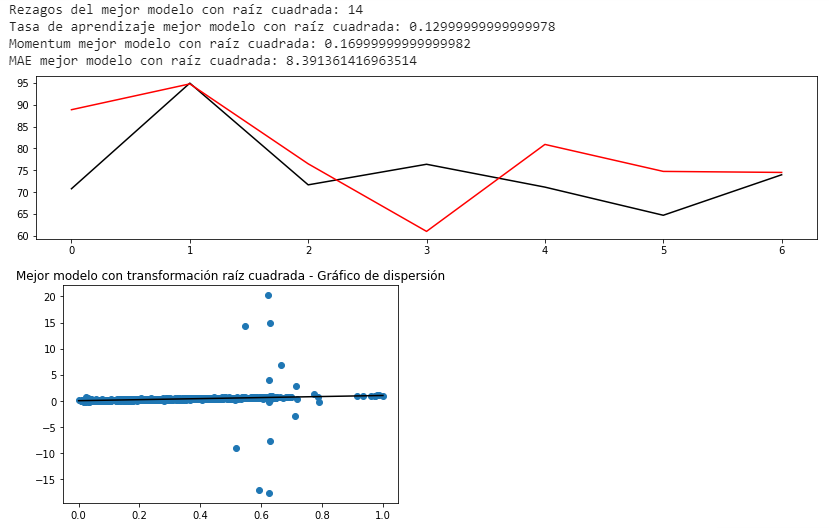

Rezagos del mejor modelo con raíz cuadrada: 14
Tasa de aprendizaje mejor modelo con raíz cuadrada: 0.12999999999999978
Momentum mejor modelo con raíz cuadrada: 0.16999999999999982
MAE mejor modelo con raíz cuadrada: 8.391361416963514


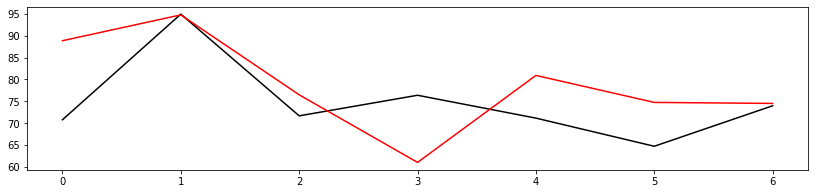

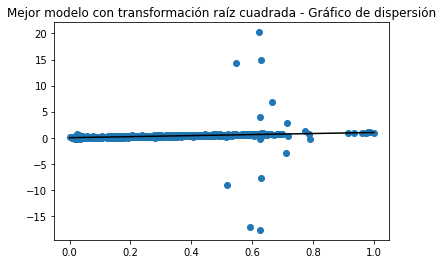

In [18]:
maeModeloSqrt = 100
for modelo in mejoresModelosSqrt: 
  if modelo is not None:
    if modelo.mae < maeModeloSqrt:
      maeModeloSqrt = modelo.mae
      mejorModeloDeModelosSqrt = modelo

plt.figure(figsize=(14,3))
plt.plot(mejorModeloDeModelosSqrt.XTest, color = "black")
#plt.plot(mejoresModelos[0].forecastedEntrenamiento, color="red")
plt.plot(mejorModeloDeModelosSqrt.forecastedTest, color = "red")
plt.figure()
plt.title("Mejor modelo con transformación raíz cuadrada - Gráfico de dispersión")
plt.plot([0,1],[0,1], color = "black")
plt.scatter(np.array(mejorModeloDeModelosSqrt.entrenamiento), np.array(mejorModeloDeModelosSqrt.forecastedEntrenamiento))
print("Rezagos del mejor modelo con raíz cuadrada: "+str(mejorModeloDeModelosSqrt.rezago))
print("Tasa de aprendizaje mejor modelo con raíz cuadrada: "+str(mejorModeloDeModelosSqrt.learning_rate))
print("Momentum mejor modelo con raíz cuadrada: "+str(mejorModeloDeModelosSqrt.momentum))
print("MAE mejor modelo con raíz cuadrada: "+str(mejorModeloDeModelosSqrt.mae))

##**Adalines: Raíz cúbica**
En el siguiente bloque de código, se prueban Adalines con la trasformación a raíz cubica con diferentes momentums, rezagos y learning_rates. Para cada combinación de momentum y learning_rate se obtiene el mejor Adaline y se agrega a la lista de mejores modelos.

In [19]:
#PRUEBA CON SQRT3
iteracionesPorModelo = 30
mejorModeloDeModelosSqrt3 = None
mejoresModelosSqrt3 = []
paso = 0.01
mejorModeloSqrt3 = None
maeModeloSqrt3 = 100
momentum_prueba = 0.4
#ITERACIONES POR MODELO

for _ in range(0,iteracionesPorModelo):
  #ITERACIONES POR MOMENTUM
  learning_rate_prueba = 0.4
  for _ in range(0,iteracionesPorModelo):
    #ITERACIONES POR LEARNING_RATE
    modelo = Modelo(
        precioPromedioConIPC, 
        max_epochs=1, 
        transformacion= "sqrt3",
        learning_rate = learning_rate_prueba,
        momentum = momentum_prueba
        )
    try:
      modelo.probar()
      mejorModeloSqrt3 = modelo.mejorModelo()
      mejoresModelosSqrt3.append(mejorModeloSqrt3)
    except:
      pass
    learning_rate_prueba = learning_rate_prueba - paso
  momentum_prueba = momentum_prueba-paso


Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encounte

###**Resultados**
Luego de probar los 6300 diferentes Adalines con raíz cúbica como transformación, se obtiene que el mejor número de rezagos es 11, con un learning_rate de 0.14 y momentum de 0.17. Con esta configuración, el MAE para el pronóstico de los siguientes siete días es igual a 8.68 aproximadamente. Finalmente, se muestran las gráficas de predicción de los siguientes siete días y la gráfica de dispersión en el entrenamiento para el mejor Adaline con raíz cúbica como transformación.  

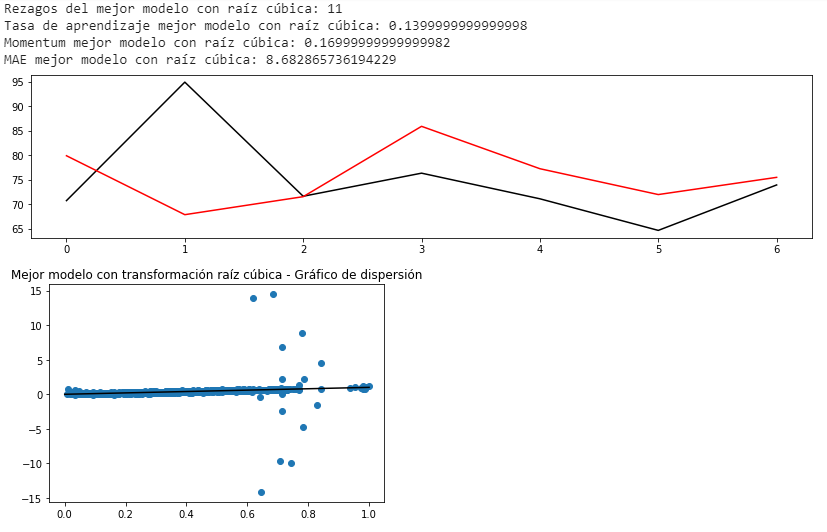

Rezagos del mejor modelo con raíz cúbica: 11
Tasa de aprendizaje mejor modelo con raíz cúbica: 0.1399999999999998
Momentum mejor modelo con raíz cúbica: 0.16999999999999982
MAE mejor modelo con raíz cúbica: 8.682865736194229


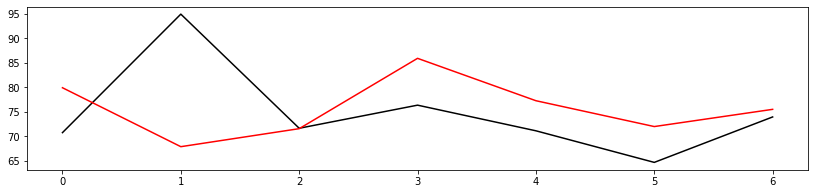

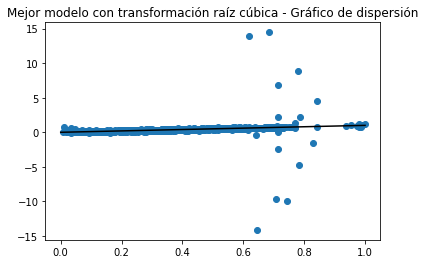

In [22]:
maeModeloSqrt3 = 100
for modelo in mejoresModelosSqrt3: 
  if modelo is not None:
    if modelo.mae < maeModeloSqrt3:
      maeModeloSqrt3 = modelo.mae
      mejorModeloDeModelosSqrt3 = modelo

plt.figure(figsize=(14,3))
plt.plot(mejorModeloDeModelosSqrt3.XTest, color = "black")
#plt.plot(mejoresModelos[0].forecastedEntrenamiento, color="red")
plt.plot(mejorModeloDeModelosSqrt3.forecastedTest, color = "red")
plt.figure()
plt.title("Mejor modelo con transformación raíz cúbica - Gráfico de dispersión")
plt.plot([0,1],[0,1], color = "black")
plt.scatter(np.array(mejorModeloDeModelosSqrt3.entrenamiento), np.array(mejorModeloDeModelosSqrt3.forecastedEntrenamiento))
print("Rezagos del mejor modelo con raíz cúbica: "+str(mejorModeloDeModelosSqrt3.rezago))
print("Tasa de aprendizaje mejor modelo con raíz cúbica: "+str(mejorModeloDeModelosSqrt3.learning_rate))
print("Momentum mejor modelo con raíz cúbica: "+str(mejorModeloDeModelosSqrt3.momentum))
print("MAE mejor modelo con raíz cúbica: "+str(mejorModeloDeModelosSqrt3.mae))

#**Conclusión y elección de mejor Adaline para pronóstico adaptativo**
Luego de la construcción y prueba de los Adalines para pronóstico adaptativo, se obtiene que la configuración con menor MAE para el pronóstico de los siguientes siete días es:
* **Transformación**: Raíz cuadrada (sqrt).
* **Rezagos**: 14.
* **Learning_rate**: 0.13.
* **Momentum**: 0.18.
* **MAE**: 8.39.

Es importante resaltar que este modelo tiene algunos puntos atípicos en el entrenamiento que aumetan el error de forma considerable, esto se observa en su gráfica de dispersión.

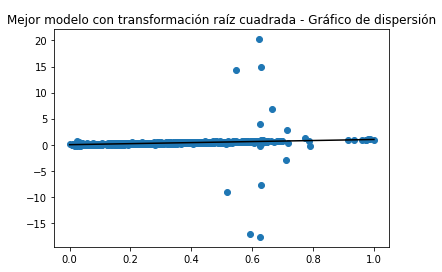